In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use("ggplot")

import shapely

In [2]:
df = gpd.read_file("data_full.shp")

In [11]:
df.head()

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE,POP10,CD112,CD113,CD115,geometry,x,y
0,37,001,021801,2010,0,6,6,6,POINT (1855812.369887527 818242.9284749853),0.546800,0.299983
1,37,001,021801,2013,0,6,6,6,POINT (1858445.050188927 819204.4370223393),0.547794,0.300346
2,37,001,021801,2009,0,6,6,6,POINT (1859301.484710351 820376.6350797059),0.548117,0.300789
3,37,001,021801,2001,0,6,6,6,POINT (1862878.489305311 820639.5996003596),0.549467,0.300888
4,37,001,021206,3007,0,6,6,6,POINT (1920007.585971883 853969.3337272498),0.571030,0.313468


In [10]:
nc_proj = "+proj=lcc +lat_1=34.33333333333334 +lat_2=36.16666666666666 +lat_0=33.75 +lon_0=-79 +x_0=609601.2199999999 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs "
df.to_crs(nc_proj, inplace=True)
df['x'] = [p.x for p in df["geometry"]]
df['y'] = [p.y for p in df["geometry"]]

norm = max(df['x']) - min(df['x'])
df['x'] /= norm
df['y'] /= norm
df['x'] -= min(df['x'])
df['y'] -= min(df['y'])

# normalized to 0-1 on x-axis, preserving scale between x and y

In [15]:
def dist(p1, p2):
    return np.sum(np.power(p1 - p2, 2), 1)

In [16]:
def pop_com(mat, pop):
    """Given a set of points and populations, as numpy ndarray and a series of equal length, computes the population-weighted center of mass."""
    return np.average(mat, weights=pop, axis=0)

In [17]:
def pop_imbalance(mat, pop):
    """Given a set of points and populations, as a numpy ndarray and series of equal length, computes the population-weighted total distance to the population-weighted center of mass."""
    return np.sum(dist(mat, pop_com(mat, pop)) * pop)

In [18]:
def df_pop_imbalance(df, x, y, pop):
    """Given a dataframe with the given columns, returns the population imbalance."""
    mat = df[[x, y]].values
    return pop_imbalance(mat, df[pop])

In [19]:
def compactness(df, x='x', y='y', district='DISTRICT', pop="POP10"):
    """Implements the population COM compactness measure: the sum of the population imbalances for each district, divided both by the number of districts and the score of a single-district plan."""
    if any([var not in df.columns for var in (x, y, district, pop)]):
        raise ValueError("{} not in DataFrame!".format(var))
    district_nums = pd.unique(df[district])
    n = len(district_nums)
    district_scores = 0
    for d in sorted(district_nums):
        district_scores += df_pop_imbalance(df[df[district] == d], x, y, pop)
    one_dist_score = df_pop_imbalance(df, x, y, pop)
    return district_scores / (n * one_dist_score)

In [20]:
compactness(df, district="CD112")

0.008942662331366865

In [22]:
compactness(df, district="CD113")

0.011086081538995356

In [21]:
compactness(df, district="CD115")

0.010313740021350735

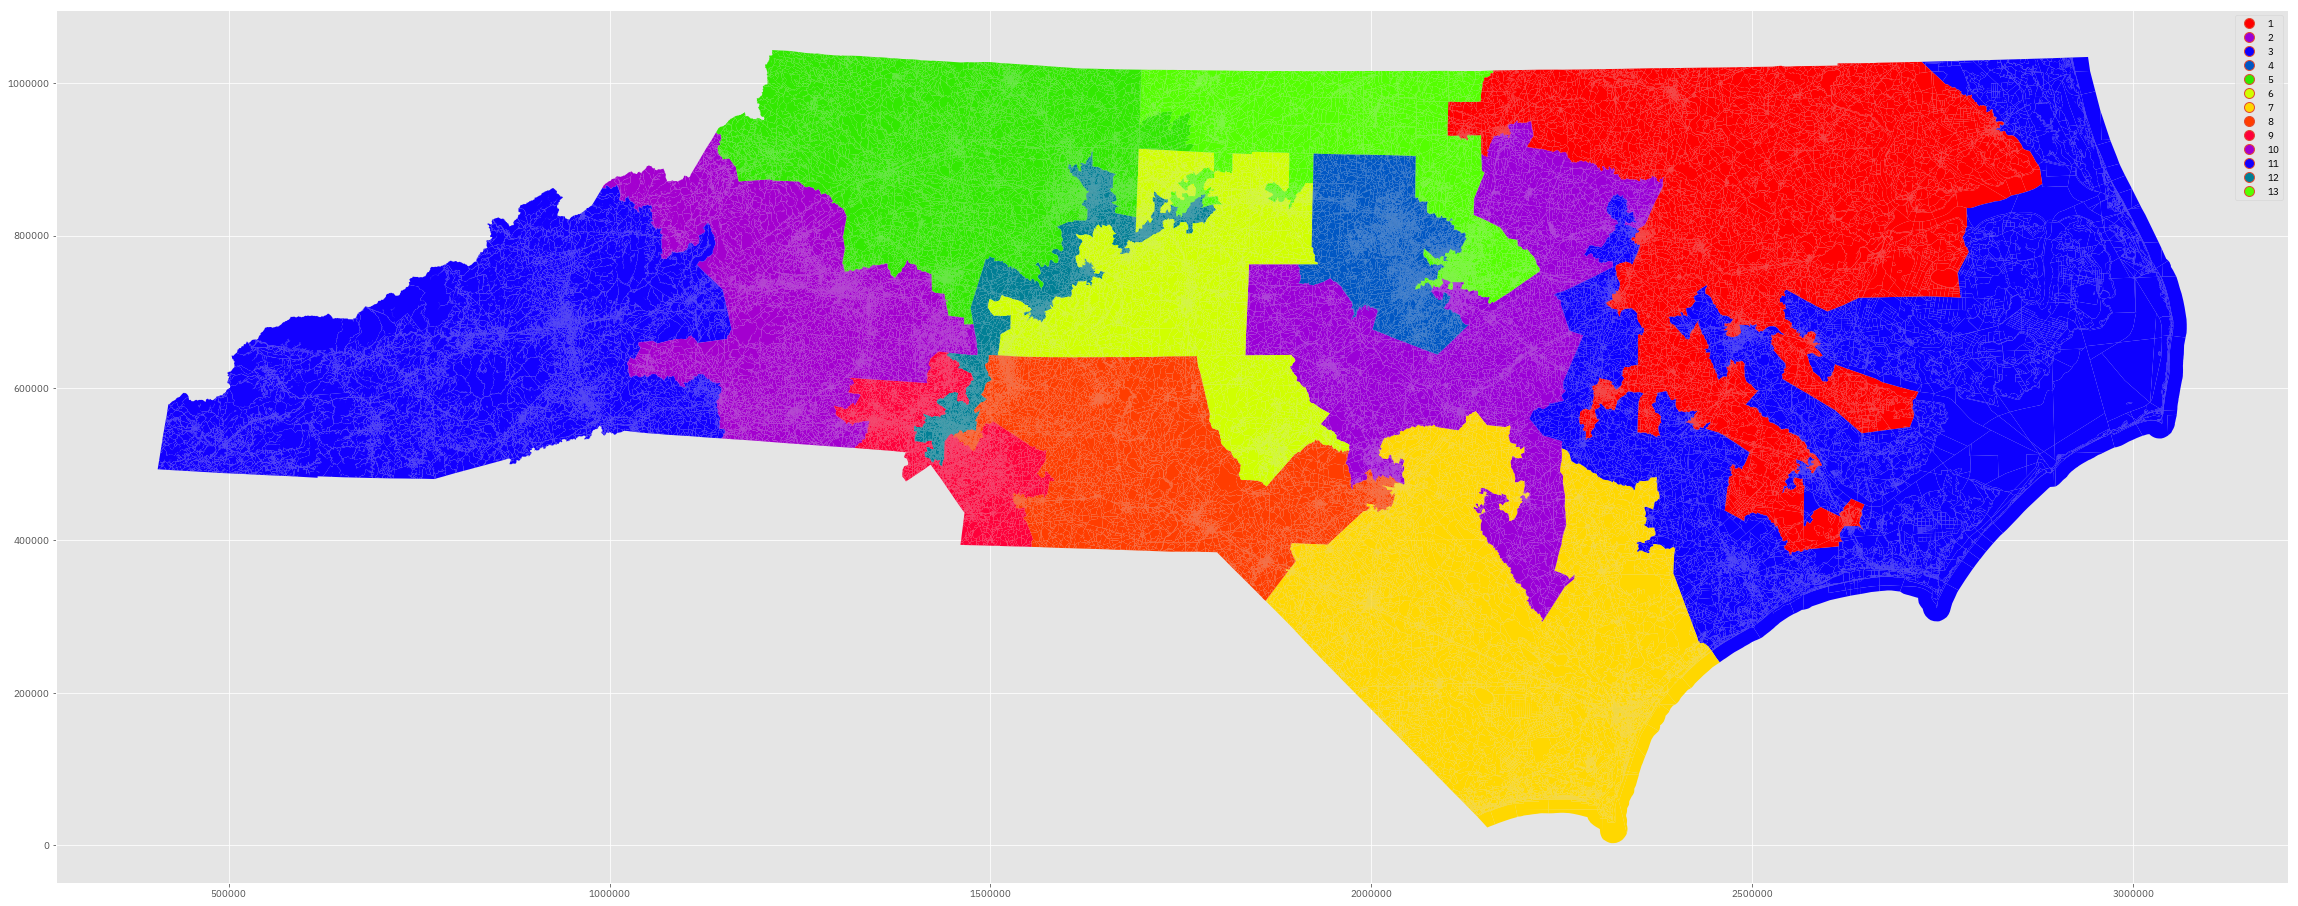

In [5]:
df.plot(column="CD112", categorical=True, cmap="prism", legend=True, figsize=(40, 20))